# Homework #1

1. create a dataloader to load the galaxy10 dataset
2. build a classifier with a fully connceted neural network 
3. write a function to compute the classification accuracy of the network prediction
3. write a training loop and train the model
4. save the loss and accuracy for both the training dataset and the validation dataset after every epoch
5. plot the loss and accuracy
6. save the trained model and model source code (in a .py file)
7. email the trained model to jonathan.shlomi@weizmann.ac.il

In [5]:
# from google.colab import files
# uploaded = files.upload()

Saving Dataset.zip to Dataset.zip


In [0]:
# import zipfile
# import io
# data = zipfile.ZipFile(io.BytesIO(uploaded['Dataset.zip']), 'r')
# data.extractall()


In [0]:
path_to_training_data = 'Dataset/train/'
path_to_validation_data = 'Dataset/validation/'

### The galaxy10 dataset

in this homework you will build a classifier for the galaxy10 dataset (https://astronn.readthedocs.io/en/latest/galaxy10.html)

but its a "special" version of the dataset created for this homework. The images have been converted to grayscale, and saved as png files in two directories, "train" and "validation". There is a seperate test dataset in a secret location, you will train a model, submit it, and we will evaluate it on the test dataset

you can submit the model once you have over 65% accuracy on the validation dataset. 


### DataLoader:

In [10]:
#first we get a list of the files in the directory

import glob
#glob gives you a list of file paths to the images
filelist = glob.glob(path_to_training_data+'/*.png')

#lets print the first 10 entries:
filelist[:10]

['Dataset/train/class4_9718.png',
 'Dataset/train/class1_3623.png',
 'Dataset/train/class2_8844.png',
 'Dataset/train/class2_6670.png',
 'Dataset/train/class2_2269.png',
 'Dataset/train/class0_1961.png',
 'Dataset/train/class4_4506.png',
 'Dataset/train/class8_639.png',
 'Dataset/train/class2_9963.png',
 'Dataset/train/class1_5569.png']

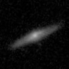

In [11]:
#to load a single image, use the PIL (python image library) function Image
from PIL import Image

Image.open(filelist[0])

In [12]:
#we want to turn it into a pytorch tensor, 
#and flatten it (since we want to train a fully connceted network)
from torchvision import datasets, transforms

img = Image.open(filelist[0])

transforms.ToTensor()(img).view(-1)

tensor([0.0314, 0.0392, 0.0118,  ..., 0.0118, 0.0118, 0.0118])

In [13]:
## we want to normalize our inputs, to have mean pixel value of 0 and standard deviation 1
import numpy as np


lots_of_images = np.concatenate( [transforms.ToTensor()(Image.open(x)).view(-1) for x in filelist[:1000]] )
print(np.mean(lots_of_images),np.std(lots_of_images))

0.09284142 0.12634498


In [14]:
#to determine the class label of an image, just look at its name:

filelist[:5]

['Dataset/train/class4_9718.png',
 'Dataset/train/class1_3623.png',
 'Dataset/train/class2_8844.png',
 'Dataset/train/class2_6670.png',
 'Dataset/train/class2_2269.png']

In [413]:
## we generate numerical labels based on the file name
import torch

labels = np.zeros(len(filelist))

for class_i in range(10):
    labels[ np.array(['class'+str(class_i) in x for x in filelist]) ] = class_i
    
#the labels need to be converted to torch.LongTensor for multi-class classification
#see the documentation at https://pytorch.org/docs/stable/nn.html#crossentropyloss
labels = torch.LongTensor(labels)

labels

tensor([4, 1, 2,  ..., 7, 1, 2])

## now, write a custom dataloader for the dataset 
remember to flatten the image to a vector of length 69*69

In [0]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, path, mean=0.0928, std=0.127, n_classes=10, augmentation_flag=False):
        self.mean = mean
        self.std = std
        self.augmentation_flag = augmentation_flag

        self.filelist = glob.glob(path+'/*.png') 
        labels = np.zeros(len(self.filelist))
        
        for class_i in range(n_classes):
            labels[np.array(['class'+str(class_i) in x for x in self.filelist])] = class_i
        self.labels = torch.LongTensor(labels)
        
        self.imgs = []
        for fname in self.filelist:
            img = Image.open(fname)
            self.imgs.append(img)

    def __len__(self):
       
        return len(self.filelist)

    def __getitem__(self, idx):

        if self.augmentation_flag:
          img = transforms.RandomRotation((0, 180))(self.imgs[idx])
        else:
          img = self.imgs[idx]
        
        x = transforms.ToTensor()(img).view(-1)
        x = (x - self.mean)/self.std

        y = self.labels[idx]
    
        return x, y

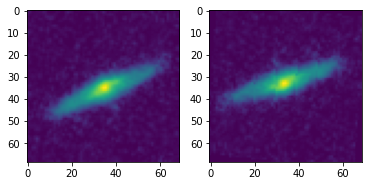

In [428]:
original_img = Image.open('Dataset/train/class4_9718.png')
img = transforms.RandomRotation((0, 180))(original_img)
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.subplot(1, 2, 2)
plt.imshow(img)

## you should get something that works like this:

In [0]:
training_ds = CustomDataset(path_to_training_data, augmentation_flag=True)
validation_ds = CustomDataset(path_to_validation_data, augmentation_flag=True)

In [430]:
some_random_idx = 900
training_ds[some_random_idx]

(tensor([-0.7307, -0.7307, -0.7307,  ..., -0.7307, -0.7307, -0.7307]),
 tensor(4))

In [0]:
## lets also go ahead and create the data loaders,
## and set the batch size
batch_size = 300
training_dataloader = DataLoader(training_ds, batch_size=batch_size)
valid_dataloader = DataLoader(validation_ds, batch_size=batch_size)

## lets plot some examples from each class

this should work if your dataloader is implemented properly

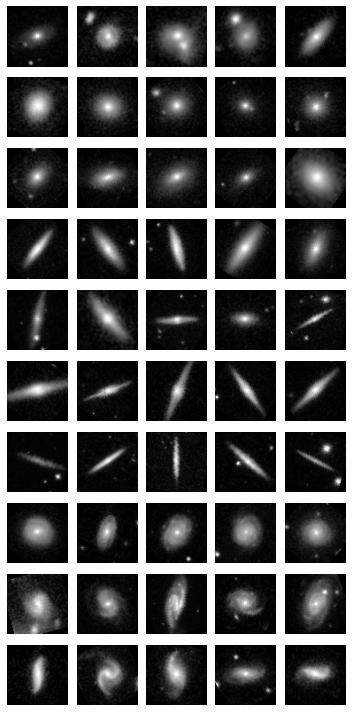

In [432]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(10,5,figsize=(5,10))

for class_i in range(10):
    idxs = np.where(training_ds.labels == class_i)[0]
    idxs = np.random.permutation(idxs)
    for plot_i in range(np.min([5,len(idxs)])):

        ax[class_i][plot_i].imshow(training_ds[idxs[plot_i]][0].reshape(69,69),cmap='gray')
        ax[class_i][plot_i].set_axis_off()
        
plt.tight_layout()
plt.show()

# Now lets build the neural network

its a classifier - it takes as input 69*69 numbers, and outputs 10 numbers

In [0]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, n_in=4761, n_out=10):
        super(Net,self).__init__()
        self.n_in  = n_in
        self.n_out = n_out
        self.n_hidden1 = 1000
        self.n_hidden2 = 700
        self.n_hidden3 = 500
        self.n_hidden4 = 300
        self.n_hidden5 = 200
        self.p_drop = 0.5

        self.linear = nn.Sequential(
            nn.Linear(self.n_in, self.n_hidden1),
            nn.ReLU(),
            nn.Dropout(p=self.p_drop),
            nn.Linear(self.n_hidden1, self.n_hidden2),
            nn.ReLU(),
            nn.Dropout(p=self.p_drop),
            nn.Linear(self.n_hidden2, self.n_hidden3),
            nn.ReLU(),
            nn.Dropout(p=self.p_drop),
            nn.Linear(self.n_hidden3, self.n_hidden4),
            nn.ReLU(),
            nn.Dropout(p=self.p_drop),
            nn.Linear(self.n_hidden4, self.n_hidden5),
            nn.ReLU(),
            nn.Dropout(p=self.p_drop),
            nn.Linear(self.n_hidden5, self.n_out),
            )
    
    def forward(self,x):
        out = self.linear(x)

        return out

In [434]:
## create the instance
net = Net()
if torch.cuda.is_available():
    net.cuda()
    print('cuda')

cuda


In [0]:
loss_func = nn.CrossEntropyLoss()

## We want to create a function that will compute the loss and accuracy at the end of each epoch

since this is a small dataset, we don't have a memory constraint and its easy to evaluate on the whole dataset at once

In [0]:
tranining_tensor = torch.stack([training_ds[i][0] for i in range(len(training_ds))]).to(cuda_device)
training_labels = training_ds.labels.data.numpy()

validation_tensor = torch.stack([validation_ds[i][0] for i in range(len(validation_ds))]).to(cuda_device)
validation_labels = validation_ds.labels.data.numpy()

In [437]:
print(training_labels)

[4 1 2 ... 7 1 2]


accuracy is defined as the number of correctly classifier samples out of the whole dataset

In [0]:
def dataset_accuracy(tensor_dataset, targets, net, loss_func):

    net.eval()

    output = net(tensor_dataset)
    loss = loss_func(output, torch.LongTensor(targets).cuda())
    output = output.cpu().data.numpy()
    prediction = np.argmax(output,axis=1)

    n_correct = len(np.where(targets==prediction)[0])
    n_total = len(targets)

    return n_correct/n_total, loss.item()

In [442]:
## create the instance
net = Net()
if torch.cuda.is_available():
    net.cuda()
    print('cuda')


cuda


In [443]:
dataset_accuracy(tranining_tensor, training_labels, net, loss_func)

(0.0437, 2.316495656967163)

In [0]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) 
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [0]:
from tqdm.notebook import tqdm

n_epochs = 200
n_training = len(training_ds)
n_batch = np.ceil(n_training/batch_size)

loss_vs_epoch = []
accuracy_vs_epoch = []

for epoch in tqdm(range(n_epochs)):

    loss_array, n_correct_array = [], []
    net.train()
    for x, y in training_dataloader:
        optimizer.zero_grad()
        pred = net(x.to(cuda_device))   
        loss = loss_func(pred, y.to(cuda_device))    
        loss_array.append(loss.item())
        loss.backward()
        optimizer.step()

        prediction = np.argmax(pred.cpu().data.numpy(), axis=1)
        n_correct = len(np.where(y.data.numpy()==prediction)[0])
        n_correct_array.append(n_correct)

    training_loss = sum(loss_array)/n_batch
    training_accuracy = sum(n_correct_array)/n_training

    net.eval()
    with torch.no_grad():
        validation_accuracy, validation_loss = dataset_accuracy(validation_tensor, validation_labels, net, loss_func)
    
    loss_vs_epoch.append([training_loss, validation_loss])
    accuracy_vs_epoch.append([training_accuracy, validation_accuracy])


In [0]:
loss_vs_epoch = np.array(loss_vs_epoch)

plt.plot(loss_vs_epoch[:,0][1:],label='training loss')
plt.plot(loss_vs_epoch[:,1][1:],label='validation loss')

plt.legend()

In [0]:
accuracy_vs_epoch = np.array(accuracy_vs_epoch)

plt.plot(accuracy_vs_epoch[:,0][1:],label='training accuracy')
plt.plot(accuracy_vs_epoch[:,1][1:],label='validation accuracy')

plt.legend()
print(f'max validation accuracy: {np.mean(accuracy_vs_epoch[:,1][-10:])}')

## save your model

In [0]:
torch.save(net.state_dict(), 'model.pt')

## Bonus round: data augmentation

implement this random rotation into your dataset object - but add an optional input argument to your dataset __init__ so that you can turn this on/off (only use data augmentation for the training dataset)

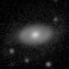

In [0]:
Image.open(filelist[1242])

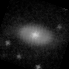

In [0]:
transforms.RandomRotation(180)( Image.open(filelist[1242]) )